In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler



In [10]:
df= pd.read_csv("C:\\Users\\amogh\\Downloads\\MalwareData\\MalwareData.csv",delimiter="|")


In [11]:
print(df.shape)
print(df.columns)
df.head()


(138047, 57)
Index(['Name', 'md5', 'Machine', 'SizeOfOptionalHeader', 'Characteristics',
       'MajorLinkerVersion', 'MinorLinkerVersion', 'SizeOfCode',
       'SizeOfInitializedData', 'SizeOfUninitializedData',
       'AddressOfEntryPoint', 'BaseOfCode', 'BaseOfData', 'ImageBase',
       'SectionAlignment', 'FileAlignment', 'MajorOperatingSystemVersion',
       'MinorOperatingSystemVersion', 'MajorImageVersion', 'MinorImageVersion',
       'MajorSubsystemVersion', 'MinorSubsystemVersion', 'SizeOfImage',
       'SizeOfHeaders', 'CheckSum', 'Subsystem', 'DllCharacteristics',
       'SizeOfStackReserve', 'SizeOfStackCommit', 'SizeOfHeapReserve',
       'SizeOfHeapCommit', 'LoaderFlags', 'NumberOfRvaAndSizes', 'SectionsNb',
       'SectionsMeanEntropy', 'SectionsMinEntropy', 'SectionsMaxEntropy',
       'SectionsMeanRawsize', 'SectionsMinRawsize', 'SectionMaxRawsize',
       'SectionsMeanVirtualsize', 'SectionsMinVirtualsize',
       'SectionMaxVirtualsize', 'ImportsNbDLL', 'ImportsNb',


,Name,md5,Machine,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,...,ResourcesNb,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize,legitimate
0,memtest.exe,631ea355665f28d4707448e442fbf5b8,332,224,258,9,0,361984,115712,0,...,4,3.262823,2.568844,3.537939,8797.000000,216,18032,0,16,1
1,ose.exe,9d10f99a6712e28f8acd5641e3a7ea6b,332,224,3330,9,0,130560,19968,0,...,2,4.250461,3.420744,5.080177,837.000000,518,1156,72,18,1
2,setup.exe,4d92f518527353c0db88a70fddcfd390,332,224,3330,9,0,517120,621568,0,...,11,4.426324,2.846449,5.271813,31102.272727,104,270376,72,18,1
3,DW20.EXE,a41e524f8d45f0074fd07805ff0c9b12,332,224,258,9,0,585728,369152,0,...,10,4.364291,2.669314,6.400720,1457.000000,90,4264,72,18,1
4,dwtrig20.exe,c87e561258f2f8650cef999bf643a731,332,224,258,9,0,294912,247296,0,...,2,4.306100,3.421598,5.190603,1074.500000,849,1300,72,18,1


In [12]:
combined = df.sample(frac=1, random_state=42).reset_index(drop=True)
combined.sample(5)

,Name,md5,Machine,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,...,ResourcesNb,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize,legitimate
12516,VirusShare_afdf8c715b8dd67d6ff9f3d3b6c54c9d,afdf8c715b8dd67d6ff9f3d3b6c54c9d,332,224,258,10,0,117248,389632,0,...,5,3.312743,2.674420,3.764385,2517.600000,48,7336,72,14,0
60953,VirusShare_d34ecf1c7641acf843b9b05b8f86ab0e,d34ecf1c7641acf843b9b05b8f86ab0e,332,224,258,11,0,111616,468480,0,...,4,4.407252,1.980482,6.115374,96625.000000,20,318464,72,0,0
40912,VirusShare_11b08bf954d1824c43977f6a6a27a291,11b08bf954d1824c43977f6a6a27a291,332,224,258,8,0,7680,312320,0,...,7,3.231834,2.111942,5.155409,1363.857143,62,3752,0,23,0
87991,VirusShare_b723d5fca97f4aba2b61b7dc050e1d75,b723d5fca97f4aba2b61b7dc050e1d75,332,224,258,10,0,117248,389632,0,...,5,3.312743,2.674420,3.764385,2517.600000,48,7336,72,14,0
83163,VirusShare_ce8a5befcfee108d905367cebcb9df39,ce8a5befcfee108d905367cebcb9df39,332,224,258,10,0,120320,385024,0,...,6,3.729824,2.458492,5.317552,2739.500000,48,9640,72,15,0


In [13]:
#now to find out of any of the numeric columns will need scaling 
#Step1: seperte the categorical from the numeric columns
num_col=[]
for col in df.columns:
    if df[col].dtype in ['int64','float64']:
        num_col.append(col)
print(num_col)

['Machine', 'SizeOfOptionalHeader', 'Characteristics', 'MajorLinkerVersion', 'MinorLinkerVersion', 'SizeOfCode', 'SizeOfInitializedData', 'SizeOfUninitializedData', 'AddressOfEntryPoint', 'BaseOfCode', 'BaseOfData', 'ImageBase', 'SectionAlignment', 'FileAlignment', 'MajorOperatingSystemVersion', 'MinorOperatingSystemVersion', 'MajorImageVersion', 'MinorImageVersion', 'MajorSubsystemVersion', 'MinorSubsystemVersion', 'SizeOfImage', 'SizeOfHeaders', 'CheckSum', 'Subsystem', 'DllCharacteristics', 'SizeOfStackReserve', 'SizeOfStackCommit', 'SizeOfHeapReserve', 'SizeOfHeapCommit', 'LoaderFlags', 'NumberOfRvaAndSizes', 'SectionsNb', 'SectionsMeanEntropy', 'SectionsMinEntropy', 'SectionsMaxEntropy', 'SectionsMeanRawsize', 'SectionsMinRawsize', 'SectionMaxRawsize', 'SectionsMeanVirtualsize', 'SectionsMinVirtualsize', 'SectionMaxVirtualsize', 'ImportsNbDLL', 'ImportsNb', 'ImportsNbOrdinal', 'ExportNb', 'ResourcesNb', 'ResourcesMeanEntropy', 'ResourcesMinEntropy', 'ResourcesMaxEntropy', 'Resourc

In [14]:
#Step2: Deciding which features need scaling
rows=[]
for col in num_col:
    minimum=df[col].min()
    maximum=df[col].max()
    rng=maximum - minimum
    mean=df[col].mean()
    std=df[col].std(ddof=0)
    if mean!=0:
        cv= std/mean #tells you how much the values are spread out from the average 
    else:
        if std !=0:
            cv = float("infinite") # the spread would be infinite if mean is 0 but variation still exists
        else:
            cv=0.0 

    uni=df[col].nunique()#cpunts the unique valus

    #check if binary
    if uni==2 and set(df[col].unique()).issubset({0,1}):
        is_binary=True
    else:
        is_binary=False

    #check if constant
    if uni==1:
        is_constant=True
    else:
        is_constant=False
    
    #appending the results for each column
    rows.append((col,rng,std,cv,is_binary,is_constant))


In [15]:
#Step3: Makinf a stat table for all the columns
stat= pd.DataFrame(rows,columns=["Feature_Name",'range','Standard_deviation','Control_Variance','Is_Binary','Is_constant'])
print(stat.head(10))

              Feature_Name         range  Standard_deviation  \
0                  Machine  3.407200e+04        1.088031e+04   
1     SizeOfOptionalHeader  1.280000e+02        5.121380e+00   
2          Characteristics  4.954900e+04        8.186753e+03   
3       MajorLinkerVersion  2.550000e+02        4.088742e+00   
4       MinorLinkerVersion  2.550000e+02        1.186263e+01   
5               SizeOfCode  1.818587e+09        5.754465e+06   
6    SizeOfInitializedData  4.294966e+09        2.101591e+07   
7  SizeOfUninitializedData  4.294941e+09        1.635282e+07   
8      AddressOfEntryPoint  1.074484e+09        3.430540e+06   
9               BaseOfCode  2.028711e+09        5.527638e+06   

   Control_Variance  Is_Binary  Is_constant  
0          2.554621      False        False  
1          0.022676      False        False  
2          1.842143      False        False  
3          0.474344      False        False  
4          3.105981      False        False  
5         23.720403

In [16]:
#Step 4: Fing the median of the standard deviation for columns that are not binary and not constant
valid_values=[]
for i in range(len(stat)):
    is_bina= bool(stat.loc[i,"Is_Binary"])
    is_const= bool(stat.loc[i,"Is_constant"])
    current_std= float(stat.loc[i,"Standard_deviation"])
    if (is_bina is False) and (is_const is False):
        valid_values.append(current_std)
median_std= float(np.median(valid_values))
print("Median STD for non constant and non binary features:",median_std)
#this tells us a baseline for the std for the columns which will tell us which features are unusually small or large

Median STD for non constant and non binary features: 13160.41336464812


In [20]:
recommend_scale_list=[]

for i in range(len(stat)):
    feat_name= stat.loc[i,"Feature_Name"]
    feat_range= stat.loc[i,"range"]
    feat_std= stat.loc[i,"Standard_deviation"]
    feat_cv= stat.loc[i,"Control_Variance"]
    is_bin= stat.loc[i,"Is_Binary"]
    is_consta= stat.loc[i,"Is_constant"]
    rec= False
    #code to find if it is recomended to scale it or not
    if(is_bin == False) and (is_consta == False):
        std_is_big= (feat_std>1000* median_std)
        if isinstance(feat_cv,float) or isinstance(feat_cv,int):
            cv_is_big= (feat_cv>2)
        else:
            cv_is_big=False
    
        if  std_is_big or cv_is_big:
            rec=True
    recommend_scale_list.append(rec)

In [21]:
#adding the result to the created stats dataframe
stat["recommended_scale"]= recommend_scale_list
print(stat[["Feature_Name","recommended_scale"]].head(20))

                   Feature_Name  recommended_scale
0                       Machine               True
1          SizeOfOptionalHeader              False
2               Characteristics              False
3            MajorLinkerVersion              False
4            MinorLinkerVersion               True
5                    SizeOfCode               True
6         SizeOfInitializedData               True
7       SizeOfUninitializedData               True
8           AddressOfEntryPoint               True
9                    BaseOfCode               True
10                   BaseOfData               True
11                    ImageBase               True
12             SectionAlignment               True
13                FileAlignment              False
14  MajorOperatingSystemVersion               True
15  MinorOperatingSystemVersion               True
16            MajorImageVersion               True
17            MinorImageVersion               True
18        MajorSubsystemVersion

In [22]:
#Now this tells me what numerical columns require standard scaling so i will apply standard scaling to these columns
sclalable= stat.loc[stat["recommended_scale"],"Feature_Name"].tolist()
scaler=StandardScaler()
df[sclalable]= scaler.fit_transform(df[sclalable])
print(df.sample(5))

                                               Name  \
106335  VirusShare_ba8a790f44b8c23b49a132e9e46a6d7d   
99735   VirusShare_5e250aebc584c94ad37c1edff6396985   
112016  VirusShare_9b528284150037c67d05e7d2fc6345cc   
100806  VirusShare_b229318017a9a7c9a77e233f82096838   
137152  VirusShare_94a094846f878ecb49ebf8003e959935   

                                     md5   Machine  SizeOfOptionalHeader  \
106335  ba8a790f44b8c23b49a132e9e46a6d7d -0.360934                   224   
99735   5e250aebc584c94ad37c1edff6396985 -0.360934                   224   
112016  9b528284150037c67d05e7d2fc6345cc -0.360934                   224   
100806  b229318017a9a7c9a77e233f82096838 -0.360934                   224   
137152  94a094846f878ecb49ebf8003e959935 -0.360934                   224   

        Characteristics  MajorLinkerVersion  MinorLinkerVersion  SizeOfCode  \
106335              258                  11           -0.321959   -0.022583   
99735               258                  10           

In [23]:
#Now for the next step i will be dropping all constant features as they wont provide any features as all their rows have the same values
print(df.nunique()>1)


Name                           True
md5                            True
Machine                        True
SizeOfOptionalHeader           True
Characteristics                True
MajorLinkerVersion             True
MinorLinkerVersion             True
SizeOfCode                     True
SizeOfInitializedData          True
SizeOfUninitializedData        True
AddressOfEntryPoint            True
BaseOfCode                     True
BaseOfData                     True
ImageBase                      True
SectionAlignment               True
FileAlignment                  True
MajorOperatingSystemVersion    True
MinorOperatingSystemVersion    True
MajorImageVersion              True
MinorImageVersion              True
MajorSubsystemVersion          True
MinorSubsystemVersion          True
SizeOfImage                    True
SizeOfHeaders                  True
CheckSum                       True
Subsystem                      True
DllCharacteristics             True
SizeOfStackReserve          

In [ ]:

#constant columns in a list(none in this dataset)
constant_columns=[]
for col in df.columns:
    if df[col].nunique()<=1:
        constant_columns.append(col)
print(constant_columns)

[]


In [27]:
df=df.drop(['Name'],axis=1)
df=df.drop(['md5'],axis=1)

In [28]:
df.sample(5)

,Machine,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,...,ResourcesNb,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize,legitimate
66719,-0.360934,224,258,10,-0.321959,-0.021249,-0.003115,-0.006173,-0.032152,-0.009715,...,-0.117593,3.672881,2.458492,5.317552,-0.006759,-0.002789,-0.011151,-0.017846,15,0
89625,-0.360934,224,258,8,-0.321959,-0.039933,-0.017050,-0.006173,-0.044114,-0.008974,...,-0.146898,5.232865,3.214913,7.250817,-0.001260,-0.002706,-0.007338,-0.017849,15,0
112427,-0.360934,224,258,8,-0.321959,-0.032193,-0.021046,-0.006173,-0.031456,-0.008974,...,-0.139572,3.774073,1.981496,6.141798,-0.006989,-0.002793,-0.011501,-0.017849,15,0
3459,-0.360934,224,8450,9,-0.321959,0.170758,-0.016368,-0.006173,0.151924,-0.009715,...,-0.124919,3.440254,1.101361,5.400079,-0.006440,-0.002789,-0.010478,-0.017846,21,1
12776,2.770595,240,8226,9,-0.321959,0.014430,-0.019267,-0.006173,-0.048842,-0.009715,...,-0.139572,3.791976,2.743231,5.105569,-0.007046,-0.002765,-0.011562,-0.017849,16,1


In [29]:
df.to_csv("Cleaned_combined_malware_dataset.csv")

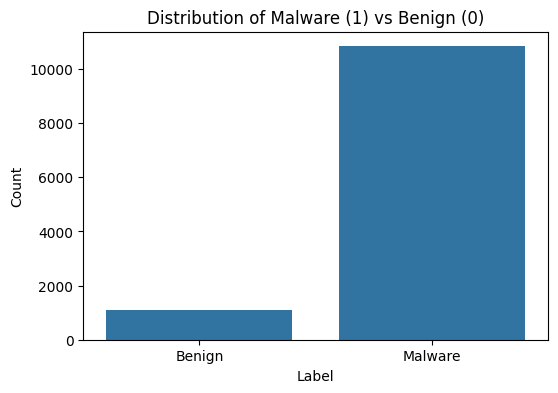

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Label distribution
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df)
plt.title('Distribution of Malware (1) vs Benign (0)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0,1], ['Benign','Malware'])
plt.show()


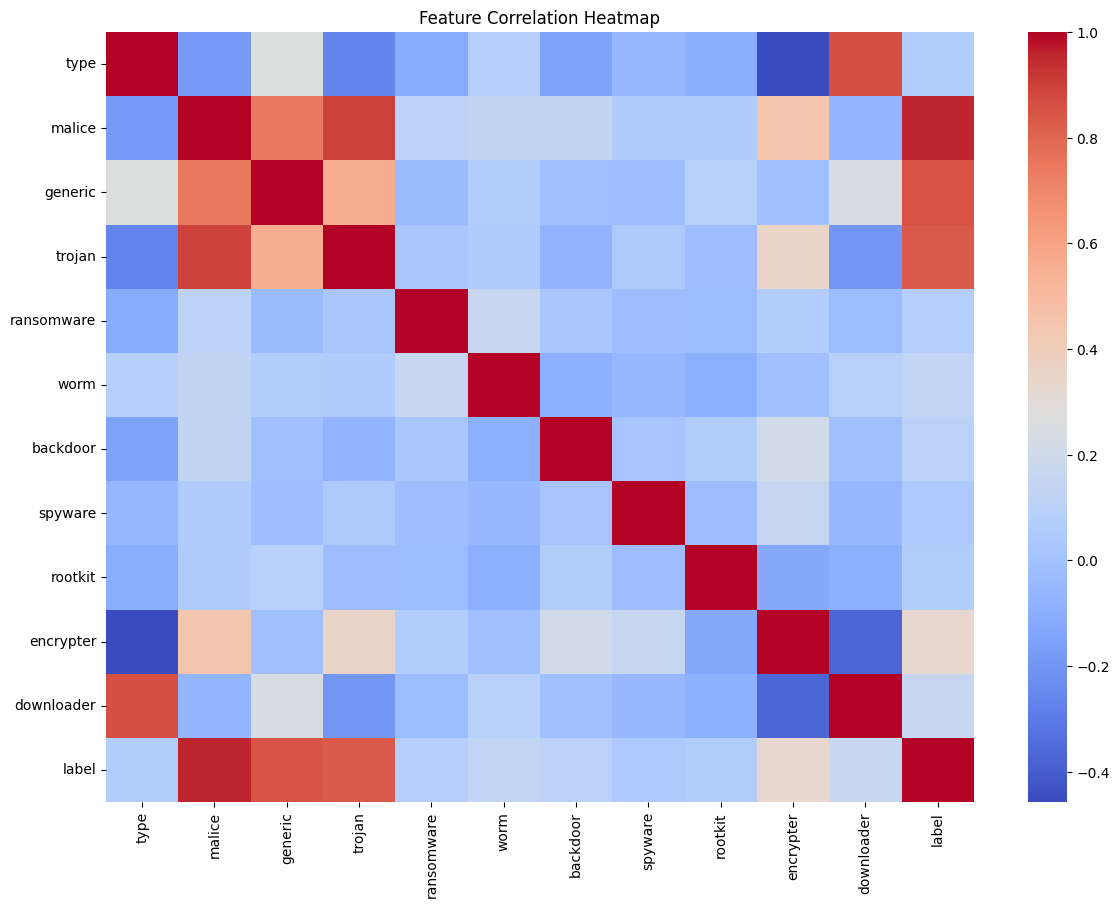

In [28]:
plt.figure(figsize=(14,10))
corr = df[num_col].corr()
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title('Feature Correlation Heatmap')
plt.show()


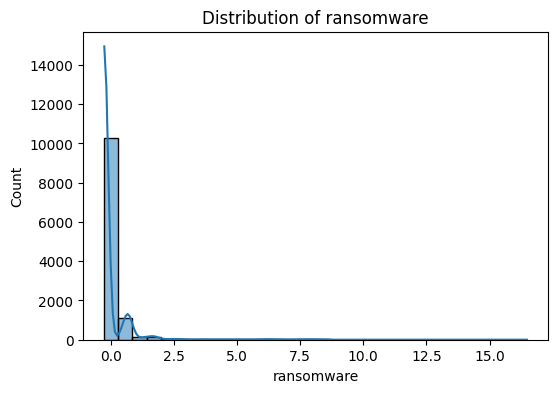

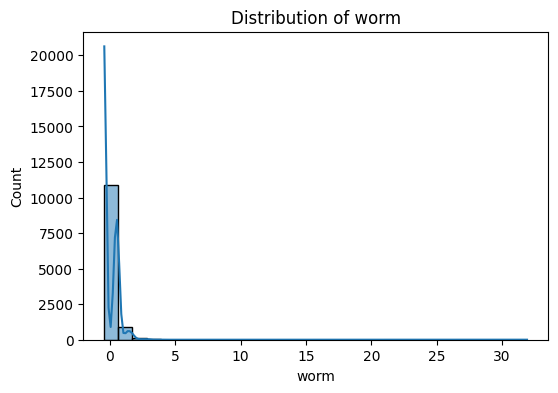

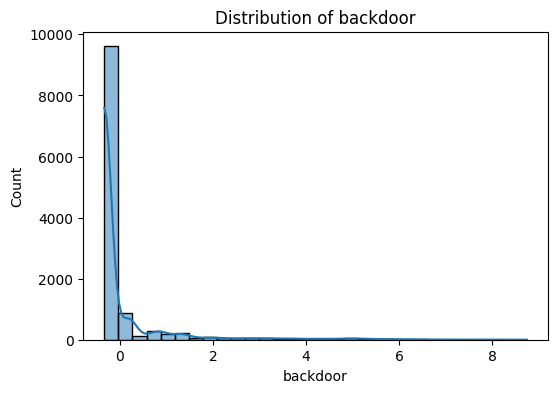

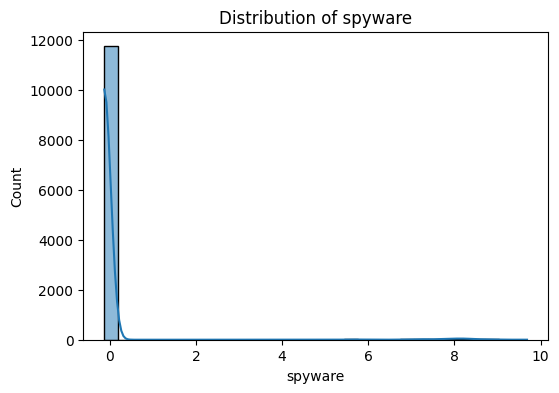

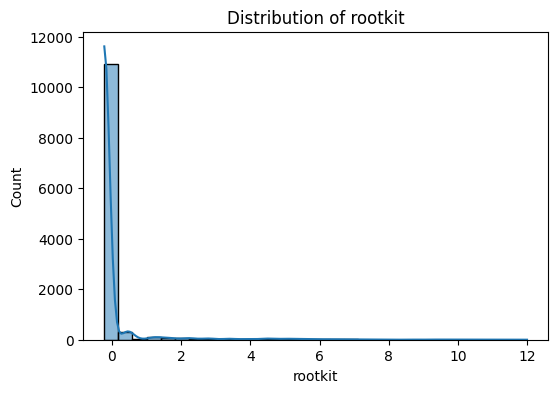

In [29]:
# Pick top 5 numerical columns (or the scaled ones)
cols_to_plot = sclalable[:5]  # or num_col[:5] if sclalable is too small
for col in cols_to_plot:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()


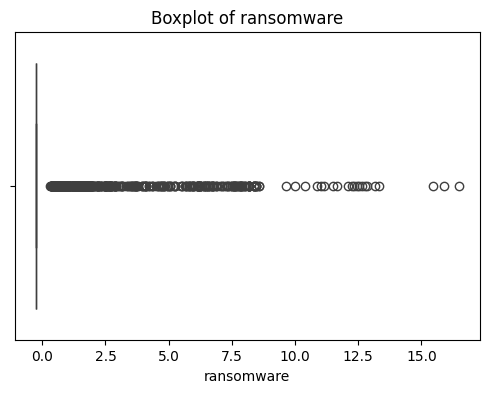

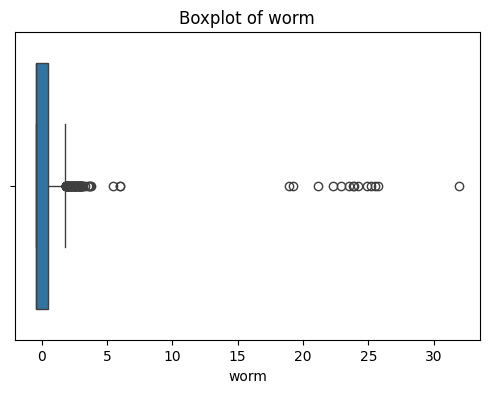

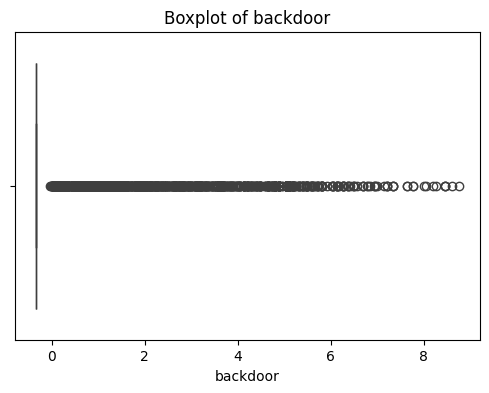

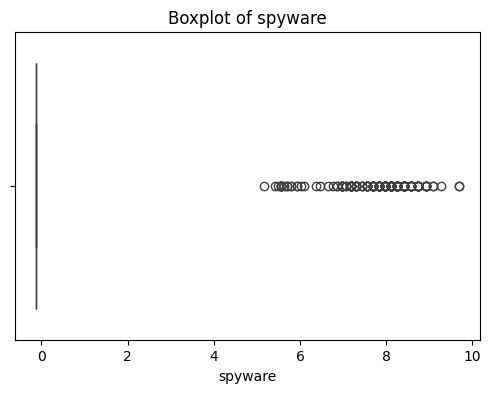

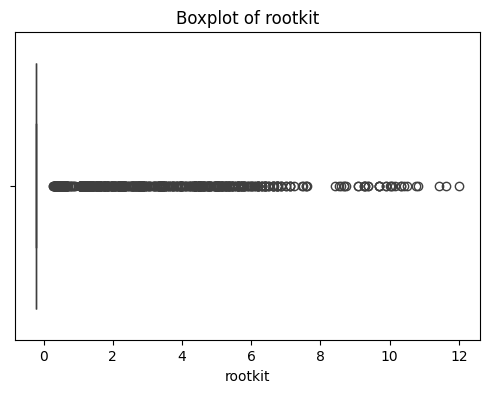

In [35]:
for col in cols_to_plot:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()


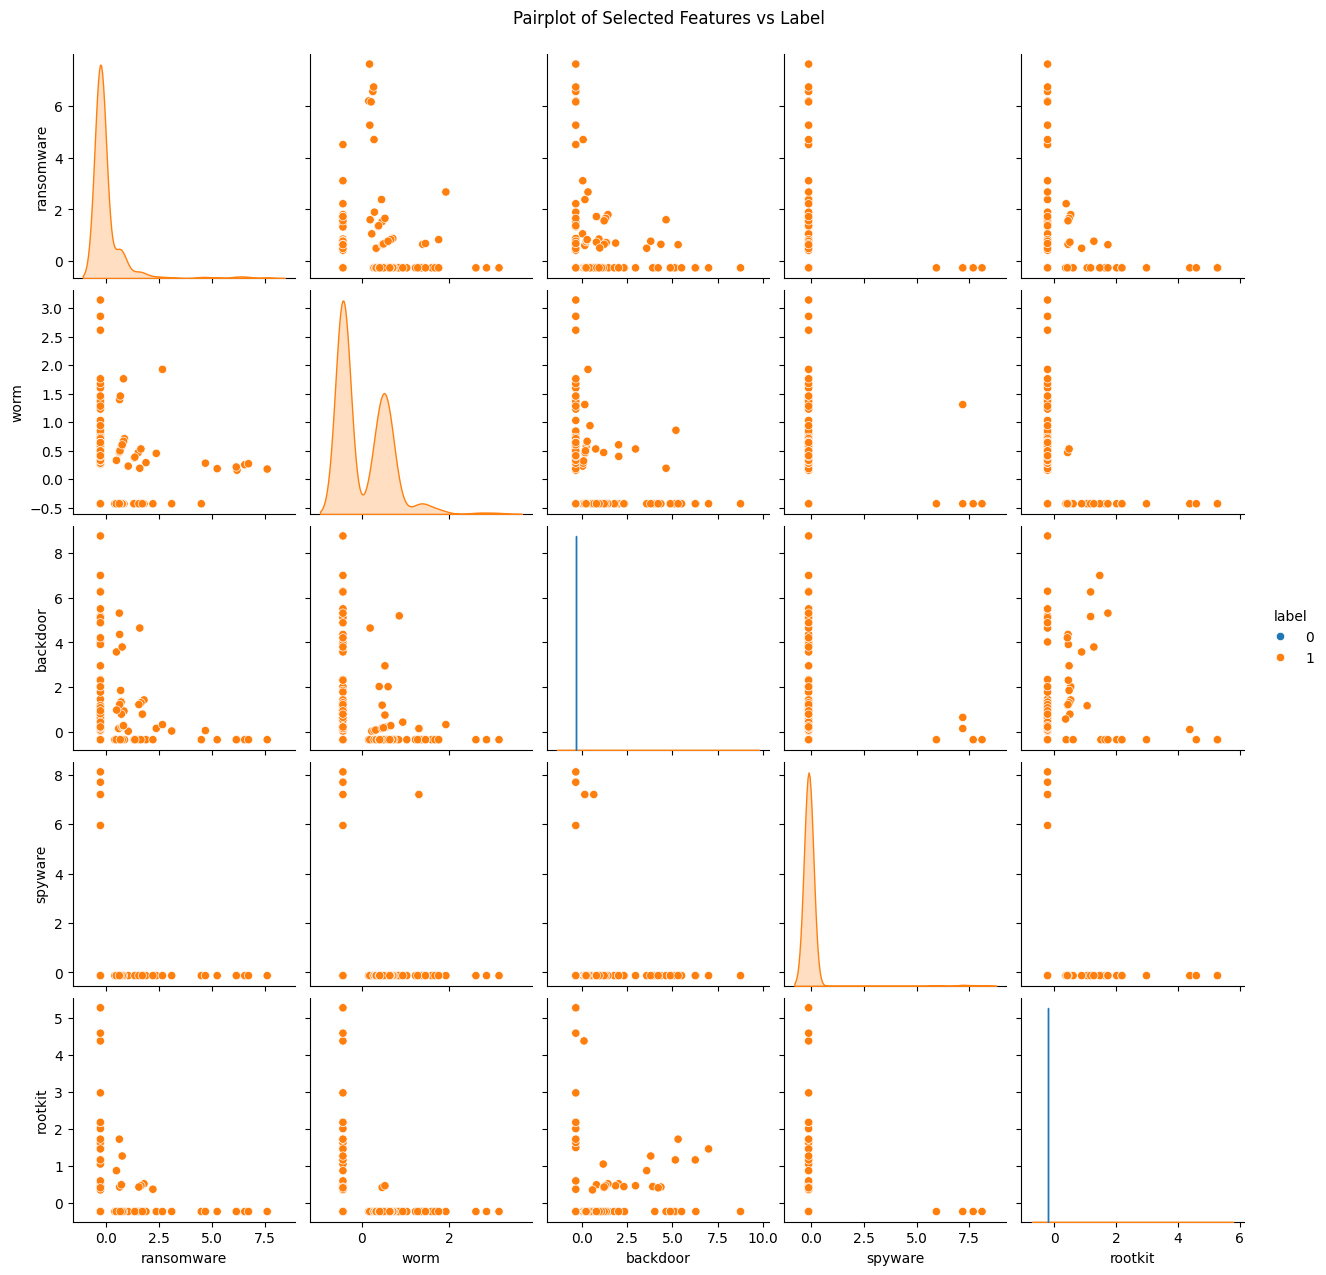

In [31]:
# Sample only to avoid lag (if dataset is large)
sample_df = df.sample(500, random_state=1)
sns.pairplot(sample_df[cols_to_plot + ['label']], hue='label', diag_kind='kde')
plt.suptitle('Pairplot of Selected Features vs Label', y=1.02)
plt.show()


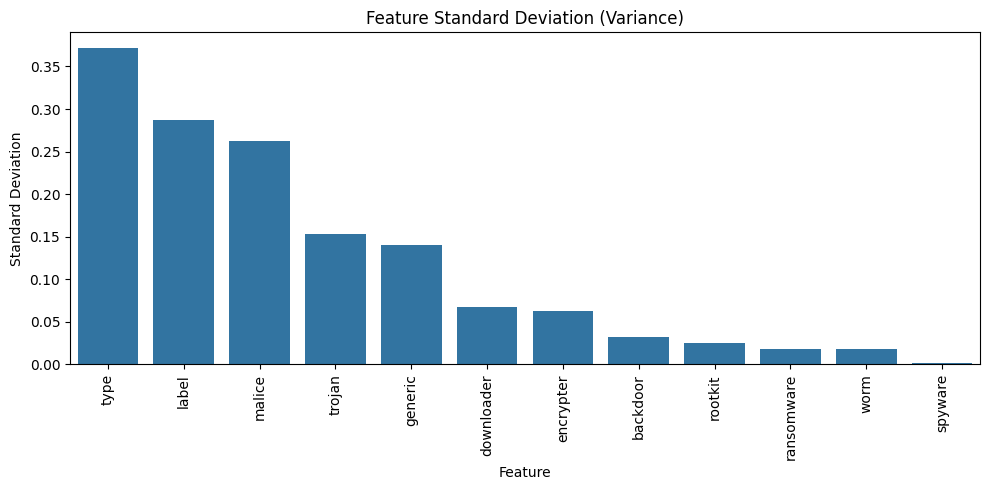

In [32]:
plt.figure(figsize=(10,5))
sns.barplot(x='Feature_Name', y='Standard_deviation', data=stat.sort_values('Standard_deviation', ascending=False))
plt.xticks(rotation=90)
plt.title('Feature Standard Deviation (Variance)')
plt.ylabel('Standard Deviation')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()


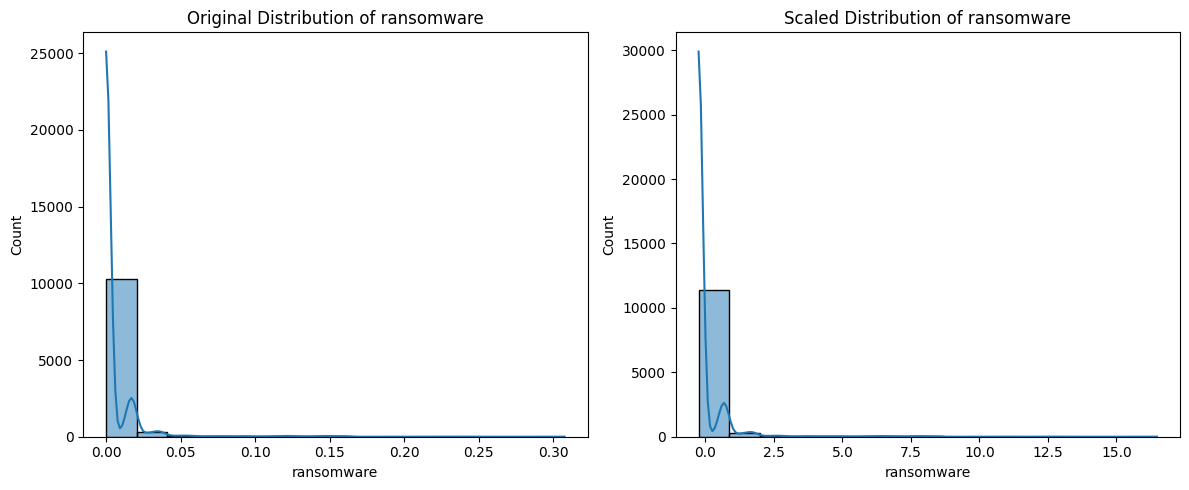

In [33]:
feature = sclalable[0] if sclalable else num_col[0]

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(df_mal[feature], kde=True)
plt.title(f'Original Distribution of {feature}')

plt.subplot(1,2,2)
sns.histplot(df[feature], kde=True)
plt.title(f'Scaled Distribution of {feature}')

plt.tight_layout()
plt.show()
